In [1]:
import os
import sys
import math
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import random

import transformers
from torch.utils.data import DataLoader
from transformers import  AutoModel, BertTokenizer, BertForSequenceClassification, get_cosine_schedule_with_warmup, AdamW, Trainer, TrainingArguments
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
import seaborn as sns

c:\Users\savel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_all(seed_value):
     random.seed(seed_value)
     np.random.seed(seed_value)
     torch.manual_seed(seed_value)
     if torch.cuda.is_available():
         torch.cuda.manual_seed(seed_value)
         torch.cuda.manual_seed_all(seed_value)
         torch.backends.cudnn.benchmark = True
         torch.backends.cudnn.deterministic = False
seed_all(42)

In [3]:
merged_df = pd.read_csv('final_data.csv')
merged_df

,Question,Category,answer_class,Answer
0,"Что делать, если я хочу изменить группу или сп...",3,11,Мы можем перевести вас в другую группу в рамка...
1,Из чего состоит основное обучение в личном каб...,4,15,"Подготовка — курсы, которые помогут подготовит..."
2,Что входит в программу помощи с трудоустройств...,9,27,Карьерный план\nПостроите свою стратегию поиск...
3,"Подскажите расписание каникул в 2024, пожалуйста",7,21,Расписание каникул на 2024:\n\n26 декабря 2023...
4,Какие инструменты и ресурсы вы предоставляете ...,9,25,Мы помогаем нашим выпускникам найти работу. Ка...
...,...,...,...,...
835,"Где находится вкладка с курсами, доступными дл...",4,14,Вкладка ЛК - Моё обучение. Здесь находятся все...
836,В какир иазбелы объединены кураы на платфлрме?,4,14,Вкладка ЛК - Моё обучение. Здесь находятся все...
837,Что вы найдете в разделе «Индивидуальные курсы»?,4,14,Вкладка ЛК - Моё обучение. Здесь находятся все...
838,Где ы могу найти иняормацию о прохождении бцтк...,4,14,Вкладка ЛК - Моё обучение. Здесь находятся все...


<Axes: xlabel='answer_class', ylabel='count'>

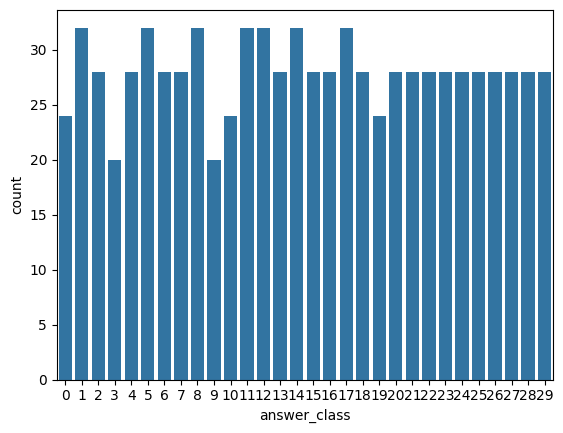

In [4]:
sns.countplot(x='answer_class', data=merged_df)

In [5]:
df_questions_true = pd.DataFrame()
df_questions_true['label'] = merged_df['answer_class']
df_questions_true['text'] = merged_df['Question']

In [6]:
df_shuffled = df_questions_true.sample(frac=1).reset_index(drop=True)

In [7]:
df_shuffled.groupby('label').size().min()

20

In [8]:
grouped = df_shuffled.groupby('label')

def split_data(group):
    n = len(group)
    train_size = n - 1
    train = group.iloc[:train_size]
    test = group.iloc[train_size:]
    return train, test

train_test_split = grouped.apply(split_data)

df_train = pd.concat([x[0] for x in train_test_split])
df_test = pd.concat([x[1] for x in train_test_split])

In [9]:
df_train.groupby('label').size().min()

19

In [10]:
df_test.groupby('label').size().min()

1

In [11]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [12]:
train_text = df_train['text'].astype('str')
train_labels = df_train['label']
test_text = df_test['text'].astype('str')
test_labels = df_test['label']

In [13]:
model_path = 'cointegrated/rubert-tiny2'
tokenizer_path = 'cointegrated/rubert-tiny2'
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=30)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 50,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = 50,
    padding = 'max_length',
    truncation = True
)

In [15]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, train_labels)
test_dataset = Data(tokens_test, test_labels)

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    return {'F1': f1}

In [17]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results", #Выходной каталог
    num_train_epochs = 10, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir="./logs", #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-4, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = train_dataset,
                  compute_metrics = compute_metrics)

In [18]:
trainer.train()

 10%|█         | 102/1020 [00:02<00:14, 62.85it/s]

{'loss': 3.1291, 'grad_norm': 8.94406509399414, 'learning_rate': 9e-05, 'epoch': 1.0}


                                                  
 10%|█         | 102/1020 [00:02<00:14, 62.85it/s]

{'eval_loss': 2.5943052768707275, 'eval_F1': 0.7001522988711328, 'eval_runtime': 0.451, 'eval_samples_per_second': 1795.858, 'eval_steps_per_second': 226.145, 'epoch': 1.0}


 20%|██        | 204/1020 [00:04<00:13, 61.14it/s]

{'loss': 2.3216, 'grad_norm': 10.952277183532715, 'learning_rate': 8e-05, 'epoch': 2.0}


                                                  
 20%|██        | 204/1020 [00:05<00:13, 61.14it/s]

{'eval_loss': 1.860060691833496, 'eval_F1': 0.7991814522030113, 'eval_runtime': 0.4495, 'eval_samples_per_second': 1801.919, 'eval_steps_per_second': 226.908, 'epoch': 2.0}


 30%|███       | 306/1020 [00:07<00:11, 61.98it/s]

{'loss': 1.6951, 'grad_norm': 7.612663745880127, 'learning_rate': 7e-05, 'epoch': 3.0}


                                                  
 30%|███       | 306/1020 [00:07<00:11, 61.98it/s]

{'eval_loss': 1.3055145740509033, 'eval_F1': 0.9050506522365447, 'eval_runtime': 0.4602, 'eval_samples_per_second': 1760.005, 'eval_steps_per_second': 221.63, 'epoch': 3.0}


 40%|████      | 408/1020 [00:09<00:10, 59.62it/s]

{'loss': 1.2148, 'grad_norm': 6.098031520843506, 'learning_rate': 6e-05, 'epoch': 4.0}


                                                  
 40%|████      | 408/1020 [00:10<00:10, 59.62it/s]

{'eval_loss': 0.9167649149894714, 'eval_F1': 0.9426721305215744, 'eval_runtime': 0.4443, 'eval_samples_per_second': 1823.138, 'eval_steps_per_second': 229.58, 'epoch': 4.0}


 50%|█████     | 510/1020 [00:12<00:08, 60.66it/s]

{'loss': 0.8678, 'grad_norm': 5.344783782958984, 'learning_rate': 5e-05, 'epoch': 5.0}


                                                  
 50%|█████     | 510/1020 [00:12<00:08, 60.66it/s]

{'eval_loss': 0.6357669234275818, 'eval_F1': 0.9694391618671969, 'eval_runtime': 0.4489, 'eval_samples_per_second': 1804.405, 'eval_steps_per_second': 227.221, 'epoch': 5.0}


 60%|██████    | 612/1020 [00:14<00:07, 58.19it/s]

{'loss': 0.6213, 'grad_norm': 7.7239766120910645, 'learning_rate': 4e-05, 'epoch': 6.0}


                                                  
 60%|██████    | 612/1020 [00:15<00:07, 58.19it/s]

{'eval_loss': 0.45676684379577637, 'eval_F1': 0.985070461945462, 'eval_runtime': 0.4528, 'eval_samples_per_second': 1788.942, 'eval_steps_per_second': 225.274, 'epoch': 6.0}


 70%|███████   | 714/1020 [00:17<00:05, 58.97it/s]

{'loss': 0.4606, 'grad_norm': 1.9951889514923096, 'learning_rate': 3e-05, 'epoch': 7.0}


                                                  
 70%|███████   | 714/1020 [00:17<00:05, 58.97it/s]

{'eval_loss': 0.33993756771087646, 'eval_F1': 0.9953131313131313, 'eval_runtime': 0.4459, 'eval_samples_per_second': 1816.572, 'eval_steps_per_second': 228.754, 'epoch': 7.0}


 80%|████████  | 816/1020 [00:20<00:03, 59.33it/s]

{'loss': 0.3626, 'grad_norm': 4.783112525939941, 'learning_rate': 2e-05, 'epoch': 8.0}


                                                  
 80%|████████  | 816/1020 [00:20<00:03, 59.33it/s]

{'eval_loss': 0.2712019979953766, 'eval_F1': 0.9953131313131313, 'eval_runtime': 0.4536, 'eval_samples_per_second': 1785.827, 'eval_steps_per_second': 224.882, 'epoch': 8.0}


 90%|█████████ | 918/1020 [00:31<00:01, 53.32it/s]

{'loss': 0.3011, 'grad_norm': 6.437182903289795, 'learning_rate': 1e-05, 'epoch': 9.0}


                                                  
 90%|█████████ | 918/1020 [00:31<00:01, 53.32it/s]

{'eval_loss': 0.2339552938938141, 'eval_F1': 0.997676282051282, 'eval_runtime': 0.4496, 'eval_samples_per_second': 1801.795, 'eval_steps_per_second': 226.893, 'epoch': 9.0}


100%|██████████| 1020/1020 [00:33<00:00, 60.43it/s]

{'loss': 0.2707, 'grad_norm': 2.1250998973846436, 'learning_rate': 0.0, 'epoch': 10.0}


                                                   
100%|██████████| 1020/1020 [00:34<00:00, 60.43it/s]

{'eval_loss': 0.22216449677944183, 'eval_F1': 0.996500754147813, 'eval_runtime': 0.443, 'eval_samples_per_second': 1828.315, 'eval_steps_per_second': 230.232, 'epoch': 10.0}


100%|██████████| 1020/1020 [00:34<00:00, 29.35it/s]

{'train_runtime': 34.7182, 'train_samples_per_second': 233.307, 'train_steps_per_second': 29.379, 'train_loss': 1.1244694167492437, 'epoch': 10.0}


TrainOutput(global_step=1020, training_loss=1.1244694167492437, metrics={'train_runtime': 34.7182, 'train_samples_per_second': 233.307, 'train_steps_per_second': 29.379, 'total_flos': 5854409460000.0, 'train_loss': 1.1244694167492437, 'epoch': 10.0})

In [36]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [19]:
model_path = "fine-tune-bert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('fine-tune-bert\\tokenizer_config.json',
 'fine-tune-bert\\special_tokens_map.json',
 'fine-tune-bert\\vocab.txt',
 'fine-tune-bert\\added_tokens.json')

In [20]:
import math
# Keep track of train models and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}

# Keep track of train and evaluate perplexity
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}
for log_history in trainer.state.log_history:
    if 'loss' in log_history.keys():
        loss_history['train_loss'].append(log_history['loss'])
        perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))
        
    elif 'eval_loss' in log_history.keys():
        loss_history['eval_loss'].append(log_history['eval_loss'])
        perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))
print('Metrics collected.')

Metrics collected.


<Axes: >

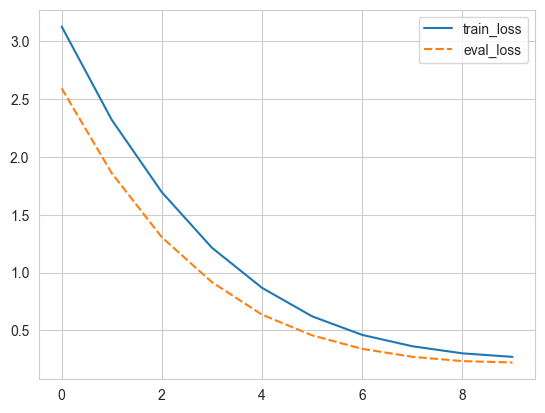

In [21]:
sns.set_style("whitegrid")
sns.lineplot(data=loss_history)